<h1><p style="color: blue">Performing hyperparameter tuning of Logistic regression, Linear-SVM, XGBoost with Word2Vec Features</p></h1>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import re
from os import path

#import cPickle
import _pickle as cPickle
import gensim
from nltk.corpus import stopwords
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
from nltk import word_tokenize

from sklearn.preprocessing import MinMaxScaler

from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from mlxtend.classifier import StackingClassifier

from collections import Counter, defaultdict
from scipy.sparse import hstack

from sqlalchemy import create_engine # database connection

import xgboost as xgb

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold

from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

#import warnings
#with warnings.catch_warnings():
#    warnings.filterwarnings("ignore")

<h3> 5. Loading Data Sheet and getting ready for apply Word2Vec Feature</h3>

In [199]:
# Load Basic Feature and advance feature data set
df_basic_feature = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
df_advance_feature = pd.read_csv("nlp_features_train.csv",encoding='latin-1')

<p style="color: blue">Now drop 'qid1', 'qid2','question1','question2','is_duplicate' columns and add both the dataframe</p>

In [200]:
# Columns dropped from basic feature dataframe 
df_basic_feature = df_basic_feature.drop(['qid1','qid2'],axis=1)

# Columns dropped from advance feature dataframe 
df_advance_feature = df_advance_feature.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

# Lets add both the truncated dataframe into one dataframe
data  = df_basic_feature.merge(df_advance_feature, on='id',how='left')

In [201]:
nan_rows = data[data.isnull().any(1)]
print (nan_rows)

            id                         question1  \
105780  105780    How can I develop android app?   
201841  201841  How can I create an Android app?   
363362  363362                               NaN   

                                                question2  is_duplicate  \
105780                                                NaN             0   
201841                                                NaN             0   
363362  My Chinese name is Haichao Yu. What English na...             0   

        freq_qid1  freq_qid2  q1len  q2len  q1_n_words  q2_n_words  ...  \
105780          2          2     30      0           6           1  ...   
201841          1          2     32      0           7           1  ...   
363362          1          1      0    123           1          21  ...   

        ctc_max  last_word_eq  first_word_eq  abs_len_diff  mean_len  \
105780      0.0           0.0            0.0           0.0       0.0   
201841      0.0           0.0            0.0 

<p style="color: blue">Found 3 such rows, we will remove these rows from the original dataset itself</p>

In [202]:
data = data[data['question1'].notnull()]
data = data[data['question2'].notnull()]

In [203]:
nan_rows = data[data.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, question1, question2, is_duplicate, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio]
Index: []

[0 rows x 30 columns]


In [204]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404287 entries, 0 to 404289
Data columns (total 30 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    404287 non-null  int64  
 1   question1             404287 non-null  object 
 2   question2             404287 non-null  object 
 3   is_duplicate          404287 non-null  int64  
 4   freq_qid1             404287 non-null  int64  
 5   freq_qid2             404287 non-null  int64  
 6   q1len                 404287 non-null  int64  
 7   q2len                 404287 non-null  int64  
 8   q1_n_words            404287 non-null  int64  
 9   q2_n_words            404287 non-null  int64  
 10  word_Common           404287 non-null  float64
 11  word_Total            404287 non-null  float64
 12  word_share            404287 non-null  float64
 13  freq_q1+q2            404287 non-null  int64  
 14  freq_q1-q2            404287 non-null  int64  
 15  

In [205]:
data.head(2)

,id,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [206]:
data.shape[0]

404287

In [207]:
data= data.sample(frac = 0.5) 
data.shape[0]

202144

<h3>5.1 let's start to make Word2Vec Features and save in dataframe "data"</h3>

In [209]:

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

stop_words = stopwords.words('english')


def wmd(s1, s2):
    s1 = str(s1).lower().split()
    s2 = str(s2).lower().split()
    stop_words = stopwords.words('english')
    s1 = [w for w in s1 if w not in stop_words]
    s2 = [w for w in s2 if w not in stop_words]
    return model.wmdistance(s1, s2)


def norm_wmd(s1, s2):
    s1 = str(s1).lower().split()
    s2 = str(s2).lower().split()
    stop_words = stopwords.words('english')
    s1 = [w for w in s1 if w not in stop_words]
    s2 = [w for w in s2 if w not in stop_words]
    return norm_model.wmdistance(s1, s2)


def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(model[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    return v / np.sqrt((v ** 2).sum())



model = gensim.models.KeyedVectors.load_word2vec_format('Data/GoogleNews-vectors-negative300.bin.gz', binary=True)
#model = gensim.models.KeyedVectors.load_word2vec_format(wv, binary=True)
data['wmd'] = data.apply(lambda x: wmd(x['question1'], x['question2']), axis=1)


norm_model = gensim.models.KeyedVectors.load_word2vec_format('Data/GoogleNews-vectors-negative300.bin.gz', binary=True)
#norm_model = gensim.models.KeyedVectors.load_word2vec_format(wv, binary=True)
norm_model.init_sims(replace=True)
data['norm_wmd'] = data.apply(lambda x: norm_wmd(x['question1'], x['question2']), axis=1)


question1_vectors = np.zeros((data.shape[0], 300))
error_count = 0
for i, q in tqdm(enumerate(data.question1.values)):
    question1_vectors[i, :] = sent2vec(q)

question2_vectors  = np.zeros((data.shape[0], 300))
for i, q in tqdm(enumerate(data.question2.values)):
    question2_vectors[i, :] = sent2vec(q)


data['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                          np.nan_to_num(question2_vectors))]

data['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                          np.nan_to_num(question2_vectors))]

data['jaccard_distance'] = [jaccard(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                          np.nan_to_num(question2_vectors))]

data['canberra_distance'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                          np.nan_to_num(question2_vectors))]

data['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                          np.nan_to_num(question2_vectors))]

data['minkowski_distance'] = [minkowski(x, y, 3) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                          np.nan_to_num(question2_vectors))]

data['braycurtis_distance'] = [braycurtis(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                          np.nan_to_num(question2_vectors))]

data['skew_q1vec'] = [skew(x) for x in np.nan_to_num(question1_vectors)]
data['skew_q2vec'] = [skew(x) for x in np.nan_to_num(question2_vectors)]
data['kur_q1vec'] = [kurtosis(x) for x in np.nan_to_num(question1_vectors)]
data['kur_q2vec'] = [kurtosis(x) for x in np.nan_to_num(question2_vectors)]

cPickle.dump(question1_vectors, open('data/q1_w2v.pkl', 'wb'), -1)
cPickle.dump(question2_vectors, open('data/q2_w2v.pkl', 'wb'), -1)


data.to_csv('data/quora_features.csv', index=False)

202144it [00:45, 4465.74it/s]
202144it [00:39, 5089.00it/s]


<h2> 5.2 Applying ML Models on newly created DATA </h2>

In [3]:
data= pd.read_csv("Data/quora_features.csv")

In [4]:
data.head(2)

,id,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,...,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec
0,1,Why do white women initiate divorce so much?,Why do women initiate the majority of divorces?,1,1,1,44,47,8,8,...,8.690568,1.0,125.797689,0.646990,0.294016,0.322897,0.110333,0.253555,-0.472383,0.007384
1,2,Is there a way on Quora to ask why a specific ...,All my questions on Quora need improvement. Wh...,1,3,17,87,92,17,18,...,6.874296,1.0,111.968110,0.508915,0.232597,0.255839,0.100403,-0.047450,-0.011347,-0.036685


In [5]:
nan_rows = data[data.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, question1, question2, is_duplicate, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio, wmd, norm_wmd, cosine_distance, cityblock_distance, jaccard_distance, canberra_distance, euclidean_distance, minkowski_distance, braycurtis_distance, skew_q1vec, skew_q2vec, kur_q1vec, kur_q2vec]
Index: []

[0 rows x 43 columns]


In [6]:
# Drop unnecessary question1 and question2 columns from "data" 
data.drop(['question1','question2'], axis=1, inplace=True)

In [7]:
data.head(2)

,id,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,...,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec
0,1,1,1,1,44,47,8,8,4,16,...,8.690568,1.0,125.797689,0.646990,0.294016,0.322897,0.110333,0.253555,-0.472383,0.007384
1,2,1,3,17,87,92,17,18,8,33,...,6.874296,1.0,111.968110,0.508915,0.232597,0.255839,0.100403,-0.047450,-0.011347,-0.036685


In [8]:
data.shape[0]

196433

In [9]:
y_true = data['is_duplicate']

data.drop(['id','is_duplicate'], axis=1, inplace=True)

In [10]:
data.head(2)

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,...,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec
0,1,1,44,47,8,8,4,16,0.250000,2,...,8.690568,1.0,125.797689,0.646990,0.294016,0.322897,0.110333,0.253555,-0.472383,0.007384
1,3,17,87,92,17,18,8,33,0.242424,20,...,6.874296,1.0,111.968110,0.508915,0.232597,0.255839,0.100403,-0.047450,-0.011347,-0.036685


In [11]:
#features= list(data.columns) 
#print(features)

#npmax= np.max(abs(data))
#print(npmax)
#npmax= np.where(np.isnan(data))
#print(npmax)

<h2> 5.3 Random train test split( 70:30) </h2>

In [12]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler().fit(data)
StandardizeData= scaler.transform(data)
StandardizeData= pd.DataFrame(StandardizeData, index= data.index, columns= data.columns)
#data = pd.DataFrame(features)#, columns = col_names)

print(StandardizeData)

        freq_qid1  freq_qid2     q1len     q2len  q1_n_words  q2_n_words  \
0       -0.410741  -0.344466 -0.547312 -0.409319   -0.571549   -0.526573   
1        0.030339   2.303063  0.897705  0.916559    1.096633    1.052211   
2       -0.410741  -0.344466 -0.480102 -0.114680   -0.386195    0.104941   
3       -0.410741  -0.344466 -0.446497 -0.468247   -0.571549   -0.526573   
4       -0.410741  -0.344466 -0.580918  0.562991   -0.571549    0.104941   
...           ...        ...       ...       ...         ...         ...   
196428  -0.190201  -0.344466  3.048430  1.122806    2.394107    0.894333   
196429  -0.410741  -0.344466 -0.681733 -0.320928   -0.756902   -0.684451   
196430   1.133041   0.317416 -0.043237 -0.291464    0.355219   -0.210816   
196431  -0.410741  -0.178996 -1.084994 -0.792351   -1.127609   -0.684451   
196432  -0.190201  -0.178996 -0.480102 -0.350391   -0.571549   -0.526573   

        word_Common  word_Total  word_share  freq_q1+q2  ...  \
0         -0.187430   -

In [13]:
#npmax= np.where(np.isinf(StandardizeData))
#print(npmax)

#nan_rows = StandardizeData[StandardizeData.isnull().any(1)]
#print (nan_rows)

In [14]:
#StandardizeData = StandardizeData[pd.notnull(StandardizeData['EPS'])]

#StandardizeData = StandardizeData[StandardizeData['EPS'].notna()]

In [15]:
X_train,X_test, y_train, y_test = train_test_split(StandardizeData, y_true, stratify=y_true, test_size=0.3)

In [16]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (137503, 39)
Number of data points in test data : (58930, 39)


In [17]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6256808942350349 Class 1:  0.37431910576496513
---------- Distribution of output variable in test data ----------
Class 0:  0.3743085016120821 Class 1:  0.3743085016120821


<h3> 5.4 Plot the confusion_matrix and call this function when we need </h2>

In [18]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 5.5 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8868882674346896


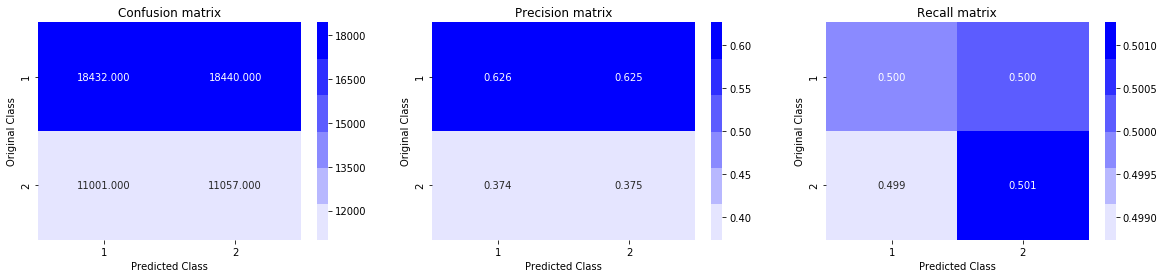

In [19]:
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 5.6 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4163610956433371
For values of alpha =  0.0001 The log loss is: 0.4089648307889474
For values of alpha =  0.001 The log loss is: 0.4089677360420138
For values of alpha =  0.01 The log loss is: 0.4248822562082028
For values of alpha =  0.1 The log loss is: 0.4646436341579551
For values of alpha =  1 The log loss is: 0.5131876989915896
For values of alpha =  10 The log loss is: 0.5399326087019145


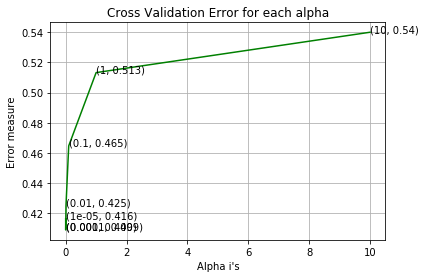

For values of best alpha =  0.0001 The train log loss is: 0.4047327488942188
For values of best alpha =  0.0001 The test log loss is: 0.4089648307889474
Total number of data points : 58930


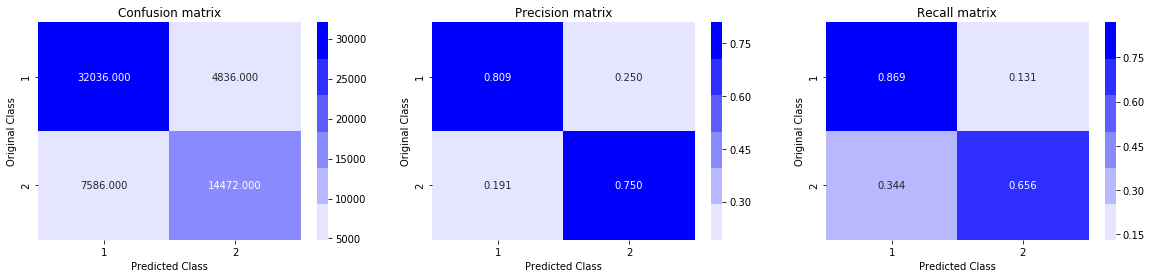

In [264]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 5.7 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.42500241257941684
For values of alpha =  0.0001 The log loss is: 0.4187505133840204
For values of alpha =  0.001 The log loss is: 0.4211436636887012
For values of alpha =  0.01 The log loss is: 0.43054913141970663
For values of alpha =  0.1 The log loss is: 0.5144980872242297
For values of alpha =  1 The log loss is: 0.6612089829555492
For values of alpha =  10 The log loss is: 0.661208982955549


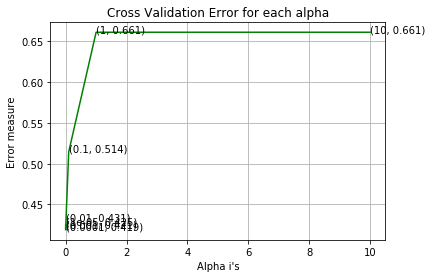

For values of best alpha =  0.0001 The train log loss is: 0.41546302987316697
For values of best alpha =  0.0001 The test log loss is: 0.4187505133840204
Total number of data points : 58930


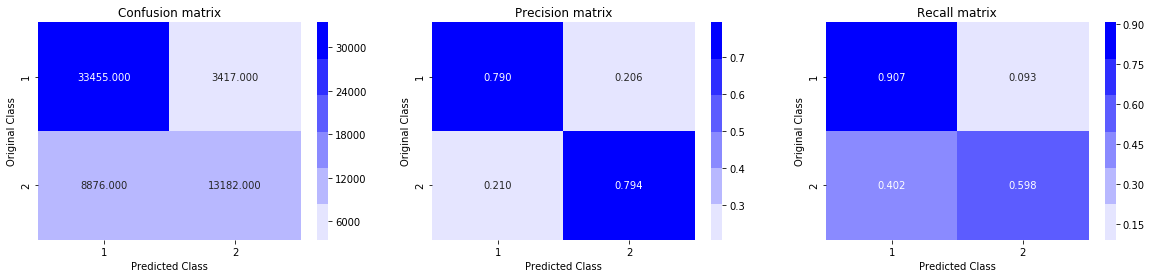

In [265]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
    

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge',max_iter=1000, random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 5.8 Applying XGBoost with hyperparameter tuning using RandomsearchCV </h2>

In [20]:
## For Hyper Parameter Optimization

param_grid = {
        'max_depth': [6, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'n_estimators': [50,100,150,200,300,400,500]}

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

        
clf = xgb.XGBClassifier(nthread=-1)

kfold = StratifiedKFold(n_splits=5, shuffle=True)
random_search=RandomizedSearchCV(clf,param_distributions=param_grid,n_iter=5,scoring='neg_log_loss',n_jobs=-1,cv=kfold,verbose=3,random_state=42)


In [21]:
from datetime import datetime
# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable

random_search.fit(X_train, y_train)

timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed: 11.9min remaining: 15.2min
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed: 14.5min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 21.2min finished



 Time taken: 0 hours 22 minutes and 36.8 seconds.


In [22]:
# Summarize results
print("Best Score is: %f from using these combination of param_grid: %s"%(random_search.best_score_,random_search.best_params_))
print()
means = random_search.cv_results_['mean_test_score']
stds = random_search.cv_results_['std_test_score']
params = random_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("mean : %f, std : (%f) with param_grid : %r" % (mean, stdev, param))

Best Score is: -0.336275 from using these combination of param_grid: {'subsample': 1.0, 'n_estimators': 400, 'min_child_weight': 7.0, 'max_depth': 15, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 1.0}

mean : -0.543048, std : (0.001112) with param_grid : {'subsample': 0.7, 'n_estimators': 400, 'min_child_weight': 10.0, 'max_depth': 20, 'learning_rate': 0.001, 'gamma': 0, 'colsample_bytree': 0.9}
mean : -0.336275, std : (0.003963) with param_grid : {'subsample': 1.0, 'n_estimators': 400, 'min_child_weight': 7.0, 'max_depth': 15, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 1.0}
mean : -0.386254, std : (0.007723) with param_grid : {'subsample': 0.9, 'n_estimators': 100, 'min_child_weight': 5.0, 'max_depth': 20, 'learning_rate': 0.3, 'gamma': 0.25, 'colsample_bytree': 0.9}
mean : -0.517357, std : (0.001350) with param_grid : {'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 3.0, 'max_depth': 20, 'learning_rate': 0.001, 'gamma': 0.25, 'colsample_bytree': 0.8}


In [23]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=15,
              min_child_weight=7.0, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1.0, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [24]:
random_search.best_params_

{'subsample': 1.0,
 'n_estimators': 400,
 'min_child_weight': 7.0,
 'max_depth': 15,
 'learning_rate': 0.01,
 'gamma': 0,
 'colsample_bytree': 1.0}

<html>
<body><b>
<p style="color: #0099cc">SO, After Applying XGBoost with hyperparameter tuning using RandomsearchCV I got the best parameter for best score. Now, I am going to apply this best parameter to XGBClassifier to getting best logg loss score.</p>
</b></body>
</html>

The train log loss is: 0.2465866826928993
The test log loss is: 0.3351238484184
Total number of data points : 58930


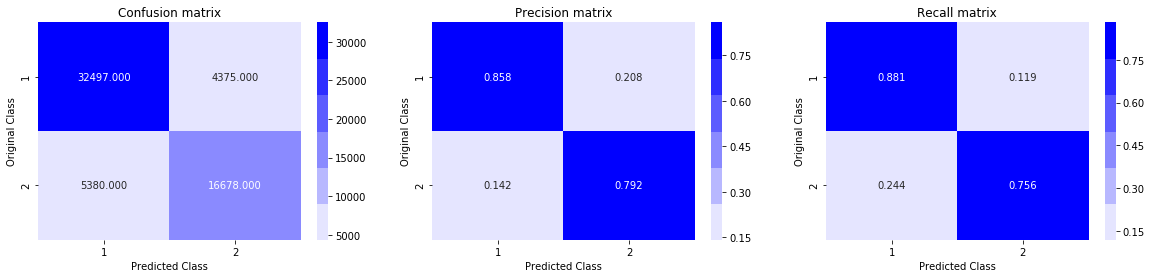

In [25]:
clf=xgb.XGBClassifier(n_jobs=-1,random_state=42,
                      max_depth=15,
                      n_estimators=400,
                      subsample= 1.0, 
                      min_child_weight= 7.0,
                      learning_rate= 0.01,
                      gamma= 0,
                      colsample_bytree= 1.0)
clf.fit(X_train,y_train)

predict_y = clf.predict_proba(X_train)
print("The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = clf.predict_proba(X_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)